In [1]:
import gc
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import datetime as dt
import keras.backend as K
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Model
from keras.layers import Input, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                confusion_matrix, classification_report

# custom Fuzzy Layers
from sofenn import SOFNN
from sofenn.layers import FuzzyLayer, NormalizedLayer, WeightedLayer, OutputLayer

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('../data/FinalDataset.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1763 entries, 12/27/13 to 10/24/18
Columns: 132 entries, com_count to bitcoin_market_cap
dtypes: float64(64), int64(68)
memory usage: 1.8+ MB


In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,bitcoin_open,bitcoin_high,bitcoin_low,bitcoin_close,bitcoin_volume,bitcoin_market_cap
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12/27/13,6065,477,1516,766,666,253,105,74,14,6,67,10,22,4,151,15,1,96.25,0.584285,4.434285,14,3,0,13.0,0.075103,0.595103,1,0,0,1.75,0.000659,0.070659,9,1,0,4.25,0.025917,0.195917,1,0,0,0.75,0.000924,0.030924,0,5,0.092715,0.006623,0.059603,0.006623,151,15,1,96.25,0.584285,4.434285,36,2,0,21.00,0.107567,0.947567,27,1,0,14.00,0.072764,0.632764,2,0,0,2.75,0.00

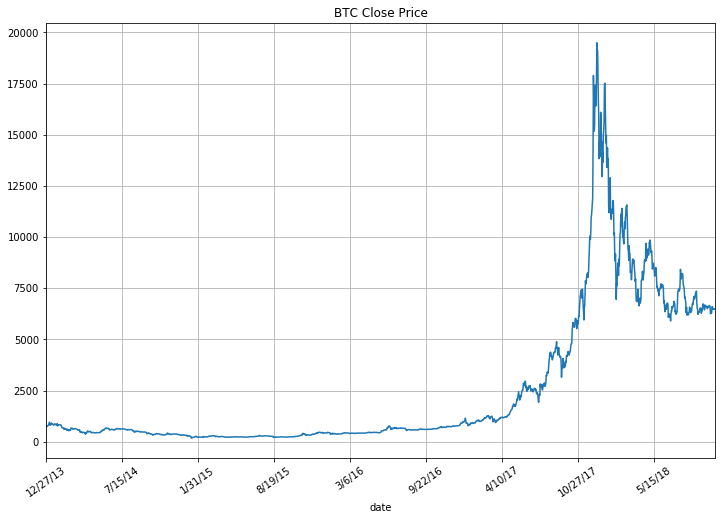

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35, figsize=(12,8))

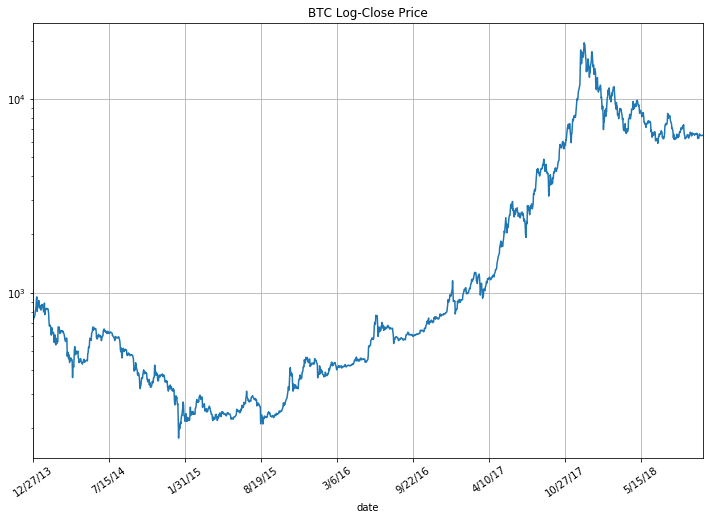

In [5]:
# show log-closing price time series
df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35, figsize=(12,8))

In [6]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  1763.0
number of months:  58.8
number of years:    4.8


# Defining Functions

## Loading and Preparing Data

In [7]:
# function to read in dataset

def get_data():
    return pd.read_csv('../data/FinalDataset.csv',index_col='date')

In [8]:
# function to drop unneeded fields

def keep_only_close(df_in):
    drops = ['bitcoin_open', 'bitcoin_high', 'bitcoin_low',
             'bitcoin_volume', 'bitcoin_market_cap']
    return df_in.drop(drops, axis=1) 

In [9]:
# function to add predicted column for tomorrow's close price

def add_prediction_field(df_in):
    # creating predicted value
    # create column to hold tomorrow's close for each day
    df_in['tomorrow_close'] = df_in['bitcoin_close'].shift(-1)
    # change in price between consecutive closing days
    df_in['day_change'] = df_in['tomorrow_close'] - df_in['bitcoin_close']
    # indicator variable to be used for predicting higher/lower days
    df_in['y'] = np.where(df_in['day_change'] >= 0, 1, 0)
        
    # drop intermediate columns
    return df_in.drop(['tomorrow_close', 'day_change'], axis=1)

In [10]:
# function to retrieve lag values to use for each feature

def get_feature_lag_dict(lag_vers=1):
    # check value of input
    if lag_vers not in [1, 2, 3, 4]:
        raise ValueError('Incorrect Version')
    
    # read in right version of file
    df = pd.read_csv('../lags/optimal_v{}.csv'.format(lag_vers))
    
    # return dictionary of features as keys and lags as values
    return dict(zip(df.feature, df.lags))

In [11]:
# function to add lags for daily features

def add_lags(df_in, lag_vers=1):
    # splitting into X/y for separate processing
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    # save list of columns for lags
    col_list = X.columns
    # create output DF
    df_out = X.copy()
    
    # creating lags
    f_dict = get_feature_lag_dict(lag_vers=lag_vers)
    # create lag columns for each other variable
    for col in col_list:
        if col not in f_dict.keys(): continue
        for lag in range(int(f_dict[col])):
            df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)

    # return and drop na
    df_out['y'] = y
    return df_out.dropna()

In [12]:
# function to remove data before certain date

def truncate_date(df_in, first_day='1999-1-1'):
    # set mask of Bool values
    mask = (pd.to_datetime(df_in.index) >= first_day)
    return df_in.loc[mask]

In [13]:
# function to rejoin training data into X/y again

def rejoin_training_data(X_train, X_test, y_train, y_test):
    Xs = [X_train, X_test]
    Ys = [y_train, y_test]
    
    df_out = pd.concat(Xs)
    df_out['y'] = pd.concat(Ys)
    
    return df_out

In [14]:
# function to create train/test X and y
def create_training_data(df_in, lag_vers=1, train_split=0.7, rescale=True, k_feat_perc=None):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train.values)
        cols = X.columns
        X_train = pd.DataFrame(scaler.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(scaler.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # select top K features to use
    if k_feat_perc:
        selector = SelectPercentile(chi2, percentile=k_feat_perc).fit(
                                    X_train.values,y_train.values)
        # index and names of remainig columns after filter
        cols = X_train.columns[selector.get_support(indices = True)]
        X_train = pd.DataFrame(selector.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(selector.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # recreate into X/y DF and add lags
    df_renew = rejoin_training_data(X_train, X_test, y_train, y_test)
    df_renew = add_lags(df_renew, lag_vers=lag_vers)
    
    # split into test train again
    X, y = df_renew[df_renew.columns[:-1]], df_renew[df_renew.columns[-1]]
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]

    # display shapes
    print('='*65)
    print('New Training Set')
    print('Training Set Dims: {}'.format(X_train.shape))
    print('Testing Set Dims:  {}'.format(X_test.shape))
    print('='*65)

    return X_train, X_test, y_train, y_test

In [15]:
# function to prep data and return DF for modeling

def prepare_data(lag_vers=1, train_split=0.7, close_o=False, 
                         first_day=None, rescale=True, k_feat_perc=None):
    # read in  dataset and initialize output df
    df_in = get_data()
    
    # drop non-price fields if needed
    if close_o:
        df_in = keep_only_close(df_in)
    
    # add prediction field
    df_in = add_prediction_field(df_in)
    
    # cut off prior to first_day
    if first_day:
        df_in = truncate_date(df_in, first_day)
    
    return create_training_data(df_in, lag_vers=lag_vers, train_split=train_split, 
                                rescale=rescale, k_feat_perc=k_feat_perc)

## Preparing Data for Training

In [16]:
# split dataset
X_train, X_test, y_train, y_test = prepare_data(lag_vers=2, train_split=0.9, close_o=False, 
                                    first_day='2016-7-1', rescale=True, k_feat_perc=50)

New Training Set
Training Set Dims: (749, 263)
Testing Set Dims:  (84, 263)


In [17]:
X_train.shape

(749, 263)

In [18]:
X_test.shape

(84, 263)

In [19]:
y_train.shape

(749,)

In [20]:
y_test.shape

(84,)

In [21]:
# balance of dependent variable values
ones = y_train.sum()
zeros = y_train.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 316
1's: 433


In [22]:
# balance of dependent variable values
ones = y_test.sum()
zeros = y_test.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 43
1's: 41


## Build, Train, Test SOFNN Model

In [ ]:
sofnn = SOFNN(X_train, X_test, y_train, y_test)


BUILDING SOFNN WITH 1 NEURONS
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 1)            526         Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 1)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 1)            264         Inputs[0][0]                     
      

Instructions for updating:
Use tf.cast instead.
84/84 [==============================] - 0s 571us/step

Accuracy Measures
Accuracy:  57.14%
MAPE:      42.86%
AUC Score: 54.51%

Confusion Matrix
          pred:no  pred:yes
true:no        18        25
true:yes       11        30

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.42      0.50        43
           1       0.55      0.73      0.62        41

   micro avg       0.57      0.57      0.57        84
   macro avg       0.58      0.58      0.56        84
weighted avg       0.58      0.57      0.56        84



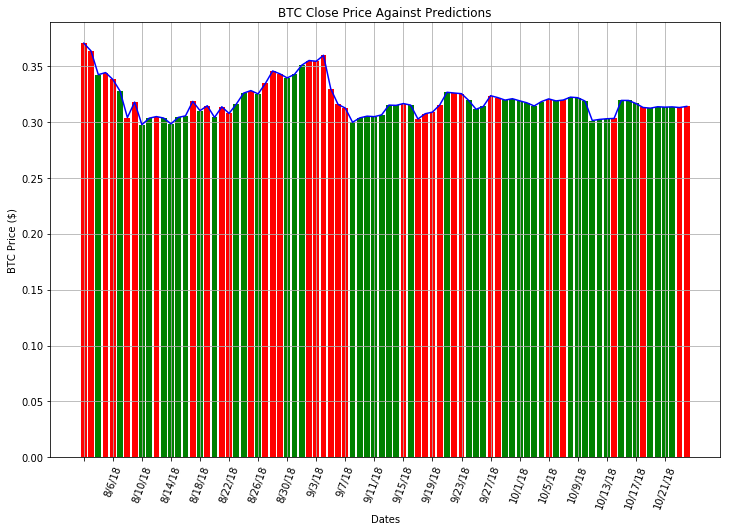

In [ ]:
sofnn._train_model()
y_pred = sofnn._evaluate_model()

In [ ]:
# function to create and train model

def run_model(rules=5, batch_size = 1, epochs=5):
    # get shape of training data
    samples, feats = X_train.shape
    
    # add layers
    inputs = Input(name='Inputs',shape=(feats,))
    fuzz = FuzzyLayer(rules)
    norm = NormalizedLayer(rules)
    weights = WeightedLayer(rules)
    raw = OutputLayer()
    
    # run through layers
    phi = fuzz(inputs)
    psi = norm(phi)
    f = weights([inputs, psi])
    raw_output = raw(f)
    #raw_output = Dense(1, name='RawOutput', activation='linear', use_bias=False)(f)
    preds = Activation(name='OutputActivation', activation='sigmoid')(raw_output)
    
    # compile model and output summary 
    model = Model(inputs=inputs, outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    # fit model and evaluate
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1] * 100
    print("\nAccuracy: {:.2f}%".format(accuracy))
    
    # print confusion matrix
    print('\nConfusion Matrix')
    print('='*20)
    y_pred = np.squeeze(np.where(model.predict(X_test) >= 0.5, 1, 0), axis=-1)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                       index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes']))
    
    # print classification report
    print('\nClasification Report')
    print('='*20)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    
    return model, y_pred

In [ ]:
# test out various nodes
for rule in [5]:
    print('{} Rules'.format(rule))
    model, y_pred = run_model(rules=rule, batch_size=30, epochs=50)

5 Rules
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            2630        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            1320        Inputs[0][0]                     
                                                                 Normalization[0][0]              
__

## Testing Model Attributes


BUILDING SOFNN WITH 7 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 7)            3682        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 7)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 7)            1848        Inputs[0][0]                     
                                                                 Normalization

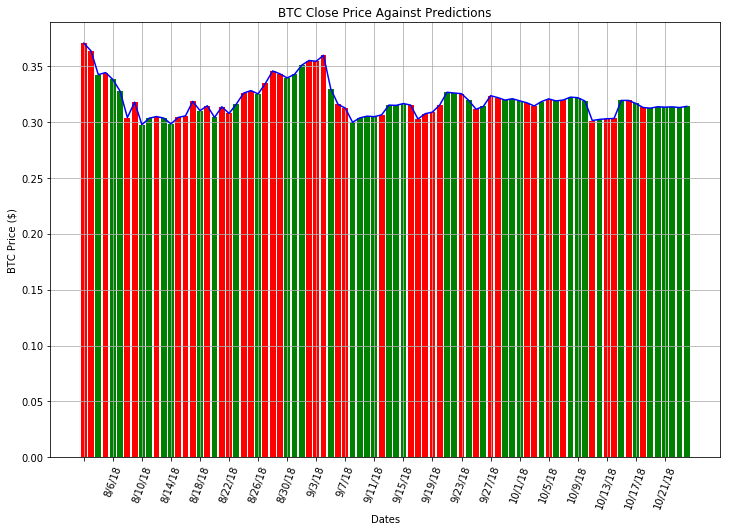

In [ ]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=7)
sofnn._train_model()
y_pred = sofnn._evaluate_model()
model = sofnn.model

In [ ]:
#define rmse and tolerance limit
E_mae = mean_absolute_error(y_test.values, y_pred)
k_mae = 0.1
prune_tol = 0.4
E = max(prune_tol * E_mae, k_mae)
E

0.19523809523809524

In [ ]:
E_mae

0.4880952380952381

In [ ]:
prune_model = sofnn.build_model()
act_weights = sofnn.model.get_weights()
prune_weights = prune_model.get_weights()


BUILDING SOFNN WITH 7 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 7)            3682        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 7)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 7)            1848        Inputs[0][0]                     
                                                                 Normalization

In [ ]:
prune_model.set_weights(act_weights)
prune_new = prune_model.get_weights()

In [ ]:
sofnn.prune_neurons(y_pred)


Pruning neurons...
Start MAE - 0.4880952380952381
Neuron   - 2
E_mae_el - 0.47619047619047616
E        - 0.3904761904761905
No neurons detected for pruning


Beginning model training...
Initial Model Evaluation
84/84 [==============================] - 0s 59us/step

Accuracy Measures
Accuracy:  55.95%
MAPE:      44.05%
AUC Score: 56.66%

Confusion Matrix
          pred:no  pred:yes
true:no        20        23
true:yes       14        27

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.47      0.52        43
           1       0.54      0.66      0.59        41

   micro avg       0.56      0.56      0.56        84
   macro avg       0.56      0.56      0.56        84
weighted avg       0.56      0.56      0.56        84



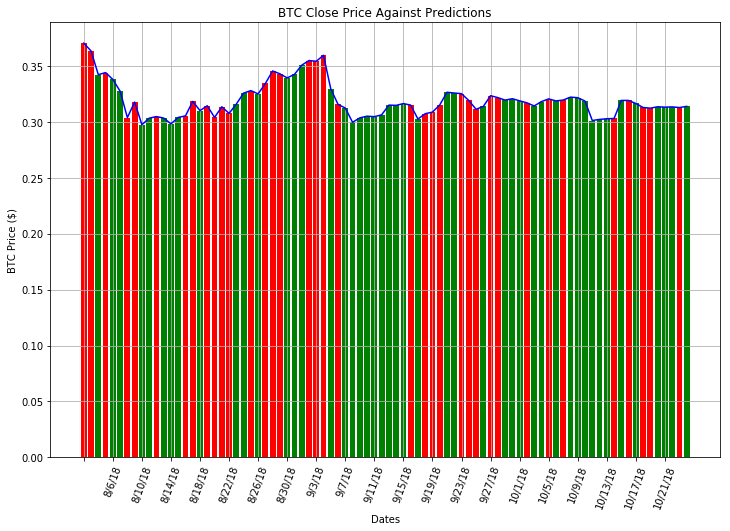


Widening centers...
Iteration 20
Iteration 40
Max iterations reached (50)

Adding neuron...

BUILDING SOFNN WITH 8 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 8)            4208        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 8)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 8)            2112        Inputs[0][0]       


Pruning neurons...
Start MAE - 0.5119047619047619
Neuron   - 1
E_mae_el - 0.4880952380952381
E        - 0.4607142857142857
No neurons detected for pruning

Widening centers...
Iteration 20
Iteration 40
Max iterations reached (50)

Adding neuron...

BUILDING SOFNN WITH 8 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 8)            4208        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 8)            0           FuzzyRules[0][0]                 
___________________________

In [ ]:
sofnn.self_organize(prune_tol=0.9, epochs=50, max_widens=50)